# Direct spectrum estimation of speech signal

## Load packages and functions

In [4]:
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using Turing
using StatsPlots

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [5]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 4000                        # specify desired sampling frequency

# inference and modelling
AR_order = 2                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Λ_meas = 1e3                            # assumed precision of measurement noise
;

## Load data

In [6]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[2*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAoA8AAIA+AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AADOJvK6s8pSPJslnbvg6dg66fiBu6ryNryMpm48PDnMvO/gAj2qPru8TNRxu77HljspMFu8pQXAPJCJ27y8NaA8KZOWvCLyIruZbs+7hqMxvOaqzzx8YwW9rFL8PL/pQr0n9xA9EIowvYT3xzxF0sm8sFRDPKTsnLyUcK26+rmwu0K2iLxzdHM8xN3UvFtAxzvtfwS9eTvmO+dDgbsY17O7yKOLPALgwry5Reg7SMYjvGj6LLl8VjO8IpkGO31nrTv3CwG98aggPA4Vnrx+atc7MBveuwqIzDuw/ae6MPIjPIdHEL1g9ho8r69WvNhK/TsLLda7NnIfPM6o77sSF9w7UTW+vCSfxzuAEga89Vcfu0gc+TsmCJS8N1WBPNwqz7wKXr48ZvIRve/VrTxM/A+9xZCTPKOQhbuMGmG81K9DPCu8QLwlhBk7Mfyfu796Dzzx93q7AODyOy/Rb7xdAcE8sj5KvL4kOLtY4CY8iYEZvDHbxrttXBA7QdX9O0OGR7wci1k8LdObu5aZkLsoCSC866RgPE0gyLrHoOM7oqVrvD7/Ezw6n9873fN8PJvzN7vnR1+7UPheO7C3GDyr/hm8sIHPO6cXQzzFkt45kZ47Or/CGDpPI4A8GeWuvAmfpDsOQEa8WsoEPKXbbrugtkE7DZD2unknezvRDbK8+1bvuaWlDDuJOG05L3k4vPm+6zqhIJ+8mWyuPDiXWLz1dze6hARruy4VdLvK6Zq7AqBdO9KgyLt7gdc77Lw0vC+o5rskz0A8Udpvu1+j9jtK8fu8meK6PM57xLwO7uk83YjDvF2hkTwIpXe85VUfvD7zlzzJzQi9QEbbPAbTwLzvAJM85W85vJBsjjyz4ha8+FrUvNw8/zs1Vtq7S5zLO0jrpbwXv7A8j7iju/9X3Tt0Vgi8S9VIPJwBsbw2CXc8BGQYuyNDCbuWz9s7g7L4u8Ztzzxi8ay85TeYPHI/MzwF6R68jLS1O5HW4LvEC9g8hXc8vJxY8DvkJ8e6+zY/PHBr1rpDnfm71bWTPALttbzzXgU9xLDCvJ+2Hj3GzrS8P2rMPMtuVryfVuQ7OH/bO6BBnryrxCY96u+uvOt4zjxZIAm9HNMMPafjtLwTGco8PbNpu7b5UDvHxcS7En6VO7IHiTuTKua6TYZsO4VPq7ufPco77xZVOwcbJ7uhnp47Xu4SPFCheLkHi1Q7bwxGOTzRSLs6NS88t3KXu1Hetzz6dcG89juSPPLu6rsfZga8b/KgOz16Krx1d+s7Xo8wPCZQr7zprnA8oef0u7magDuSP7M8u9Z3vGaH4ruXg3y7U+Y3PO/UEjwNurw7IsYrvMlAaLqP7Kg7evIlPLgybbwmK1w81VosPBUVKLsO7Km7R9pBO7cJNLxFOVs8vDulvEKv9zxHBMC8aehqPGuxlrv7vNw7RBIDPI2Oz7yl2EA8f3QXPNbwsjssEU28RnIrvIg+hjwvjGU7+8VBvDJKAjxhkUi766rovC1zDjyOYvu7qm+2PNsBXLz40gc8AdJVvC3rXDxCrXW8dWNXPGcJrLuV/Q478WG+uu9hHLwwrLc6I6RrPPjJdry1a4a7EeYxvP7ldLsK+M07cnOWu+gCaTqBxvI7B7S1vE2X2DrSzhm8RN4yPPF2obxHE5G7ioenuymYCLseJsQ7Kks/vMZypTvQomW8YgaluYO0r7vKzAu8sF5/PCZAfbxc9hU87qBAO+gxhbyAjgI8EoHzO5v4prwxxk48Mp2EvLY8oTwSMR68rP1+uwg5JDv05/+7UjVJOmI5crua9G68lbNaO4sWXbtaHp+72sp+vKr5T7xYkyy8Q5aLPM0zq7yh5+m7Y3nHO9K7qDvPBA27AaS6vEaarTsn8Bm8krm8uv9iArxdjNK7Z3qAPBsNcby3FrA7h9zwvARTqDy9Z4m8908iPOvKvrqT4QW8QLllPNUidbx08Dw8nGe1u2uM9bsSoa88ORoFPLlmBjztKgi5zkFCOvuSTzwufgm8F5QePA0SRzuoItE7Nn4ePMZiHbyNRAq73/w4PGngJ7ugSJ48nPLJvAEVxTy6GCi8qDNRPKIxmzuw51G8i7yCPI7t+TiqUYE7tkdkvErYtzzo9o28+pxZPMNoAzr+ysQ8GZD+vKVdDT2qmxS90jypPMI8sjsApZ88hdmJvNFrtDyuMjC8Y9k+Oy8X2TuI6II6+3fJPIZ3p7w4r3I8SvgzvLPp9DtwKzw650aeubK0FDylmfw70b8nvG37cTzhK9s6dvPUu0xSSToFhXS8I5mwPGsv4LxEixS7dopHvHVUhbx4Elk8V5SXvDga+btqYRQ7B+wfvI/4fbxeoom7OkR6PAh397uozgq8+pNlO3QuAjx8eJA7lZEvu40vW7p0AKi7jU6IPK2SXTuoltQ77xtwuwoXHrsWboY8Ido/vRXZAj10D4q8fQKUPDzXmLqfeJe8Usq9PPOBpLy7G7M8ethDuwa9pbtWiac881VovEq3bzsexq27BJS+u9HFtzzNnJi87JOnO+FsbDwZ4XS7MSVkvJajj7w5ONQ8HdwWvMxcJzvDLzK9nWQYvIxYETxxmV85l+omPVFD+7wuWro899AGPKsPt7tp1188XW7Su9+2WjzJl5I7/oxyumgDpzvzoi08G6tJPGxp0zvzmo67MtU/vMXJJLzh8e07syPcPJQLejoVVqm6T9AMPetQQLx0PW47y9j1u89IEz12ukI6Y+4LvAcB5LsNbYE8wEr4OhDSRrw6lLw65soUvDFhtDy5IQG9YUDfPEuOE7wetng8RmkpvGK5Nry4xpM8aB5DvCvPizx5zIK8gSZuPAqkD7wZDuA7bJJEvN0fEzhVcnm7VgNavMIOm7vnNIm8ZljCu/lNL7zMMbK7z/hFO4gI/rl1gKs7sVS6O8itQjwbQZk8TVtHPJ3oljxyvyo8/BG6PKn3yjzcRKA8NtITPDxN+Dv8X3s7pyZhuwjrFrzd1bO8HSKfvIJ75bwdkfG8/t/qvLwxjLw8HOK5FZnJPJdBZz0BbI89vBuoPSJNpT2ddvw96vISPj9WyD0yOxg8FeHfvU63G76PSyC+GR3pvTLamL1Qh3a93CJ/vQM5ub1XP8W9jmmHvWBOMD1x2DM+Hz6WPvAS0j5varU+TWq5PQDNCr7mA4a+PGw7vjjDUr0vBq899f3nPZd/xrsNUQm+tJCGvpwaer6++C2+I8UPvY+hUD2XTVo9uXWYPCYQjjw5UB0+bKifPuJd0T4bF48+GPxePcdLJ75u4m++U/IxvkmHw7y93cw9ND7NPYdhXbxqpyu+f6mFvjozaL6lK/K9Roa2PFz3nT3rxjY9Vv7JvC4y0LttAi0+NOysPgsl8j40S6I+y7JoPXBjWb5745G+4I1BvleA6zsfXSI+MkYuPjdePjx4NSy+icOUvrDqgL42DNW9ryApPYig4z2M5VI9ZToRvUbIs73ErJY9y8OZPr629D79mOg+MzUYPuUNDb5XTKa++/t/vuHggb0k8Qo+I4tRPtKVqT0HzQ6+a1iZvnYjn77w5S2+POW0OwqGxj0xA5A9x95avZyNBb4pUbq9WLgdPvcguz4M5gM/lBa4PsXTAT3QNoS+Y02vvnEMSr7Y6PE8vVk9PjSMOD4CHCy8MFBovtacp74hlIq+nWGqvTlBgj0JB8o9G6APPLXQ9721hRy+9qtdvWHraz6wLd4+bxIIP8rTmz5K4Ua9vp6YvuxPrL4Bcw6+hnmXPSWBSj5bsAo+QCGEvWkLhL5nu6C+WcZnvp2pW71J7nw9w+57Pea6Ib37ZBy+hY0svnvqZb2O0FQ+RAzQPqdj/D4/J6U+9ustvbBkj75woKy+IvMnvoa+Gz3vdiI+5MDkPezSir10t

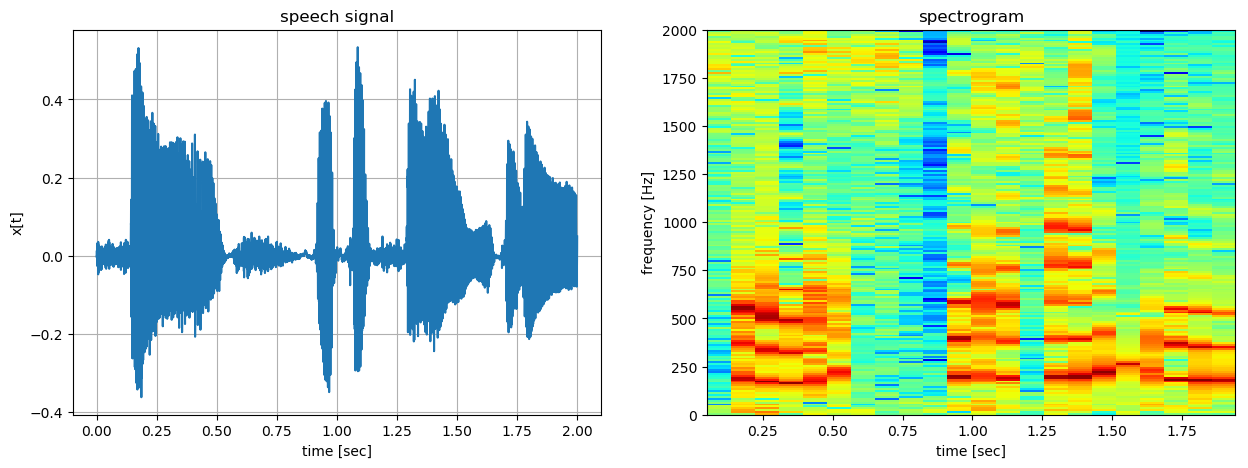

In [7]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [36]:
@model AR_model(x, AR_order, Λ_meas) = begin
    
    θ1 ~ Normal()
    θ2 ~ Normal()
    
    σ0 ~ InverseGamma(2,3)
    σθ ~ InverseGamma(2,3)
    
    xθ = Vector(undef, length(x))
    #xtot = Vector(undef, length(x))
    x0 ~ Normal(0, sqrt(σ0))
    
    nr_segs = 20
    
    # Draw weights.
    π1 ~ Beta(1,1)
    π2 = 1-π1
    
    z = Vector(undef, nr_segs)
    for zn = 1:nr_segs
        z[zn] ~ Categorical([π1, π2])
    end
    
    xθ[1] ~ Normal()
    xθ[2] ~ Normal()
    
    #for n = 3:length(x)
    #    xθ[n] ~ Normal(θ1*xθ[n-1] + θ2*xθ[n-2], sqrt(σθ))
    #    xtot[n] = [xθ[n], x0]
    #    x[n] ~ Normal(xtot[n][z[Int(ceil(n*nr_segs/length(x)))]], 1/sqrt(Λ_meas))
    #end
    for n = 3:length(x)
        xθ[n] ~ Normal(θ1*xθ[n-1] + θ2*xθ[n-2], sqrt(σθ))
        if z[Int(ceil(n*nr_segs/length(x)))] == 1
            x[n] ~ Normal(xθ[n], 1/sqrt(Λ_meas))
        else 
            x[n] ~ Normal(x0, 1/sqrt(Λ_meas))
        end
    end
    
end

##AR_model#1037 (generic function with 2 methods)

## Algorithm generation

In [37]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 5
ϵ = 0.1
τ = 10

#sampler = HMC(ϵ, τ)
#sampler = NUTS(200, 0.6)
sampler = Gibbs(PG(100, :z), HMC(ϵ, τ, :θ1, :θ2))


# Start sampling.
chain = sample(AR_model(x_time, AR_order, Λ_meas), sampler, iterations);

Sampling: 100%|█████████████████████████████████████████| Time: 1:32:58


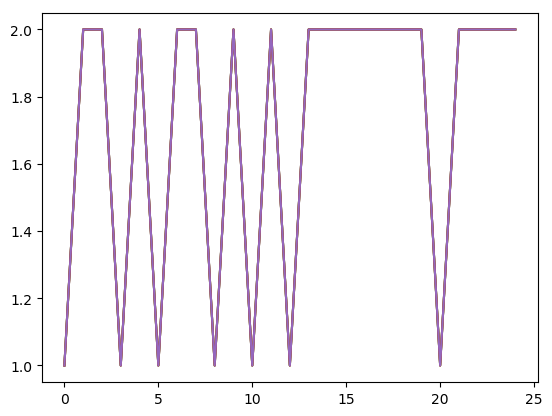

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000033636518>
 PyObject <matplotlib.lines.Line2D object at 0x0000000033636668>
 PyObject <matplotlib.lines.Line2D object at 0x00000000336367B8>
 PyObject <matplotlib.lines.Line2D object at 0x0000000033636908>
 PyObject <matplotlib.lines.Line2D object at 0x0000000033636A58>

In [38]:
plt.plot(Array(chain[:z])')

In [39]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se     mcse     ess   r_hat
  ──────────  ───────  ──────  ────────  ───────  ──────  ──────
          x0   0.0282  0.0000    0.0000  missing  4.0000  1.0801
       xθ[1]  -1.2939  0.0000    0.0000  missing     NaN     NaN
       xθ[2]   0.8182  0.0000    0.0000  missing  4.0000     Inf
       xθ[3]   1.2679  0.0000    0.0000  missing     NaN     NaN
       xθ[4]   0.7588  0.0000    0.0000  missing     NaN     NaN
       xθ[5]  -0.4161  0.0000    0.0000  missing  4.0000  1.0801
       xθ[6]   0.7484  0.0000    0.0000  missing     NaN     NaN
       xθ[7]  -0.4128  0.0000    0.0000  missing  4.0000  1.0801
       xθ[8]  -0.1511  0.0000    0.0000  missing     NaN     NaN
       xθ[9]   1.3012  0.0000    0.0000  missing     NaN     NaN
      xθ[10]   0.8218  0.0000    0.0000  missing     NaN     NaN
      xθ[11]   1.9630  0.0000    0.0000  missing  4.0000     Inf
      xθ[12]   0.6059  0.0000    0.0

## Predictions

In [9]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, μ_x_pred, label="prediction"), ax[2].plot(t, μ_x_pred, label="prediction")
ax[2].fill_between(t, μ_x_pred .- sqrt.(var_x_pred), μ_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(0.8, 0.81), ax[2].set_ylim(-0.25,0.25), ax[1].set_ylim(-0.25, 0.25)

audioplayers(x_time, μ_x_pred, fs=fs_desired)
;

UndefVarError: UndefVarError: μ_x_pred not defined

## Visualize parameters

In [10]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)])
    
    plt.fill_between(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .- sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .+ sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients θ"), plt.title("Evolution of auto-regressive coefficients")
;

UndefVarError: UndefVarError: μ_θ_mem not defined

In [11]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_γ_mem[k]-1)/b_γ_mem[k] for k = 1:length(a_γ_mem)])
ax[2].plot(t, [10*log10.(b_γ_mem[k]^2/a_γ_mem[k]) for k = 1:length(a_γ_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of γ"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of γ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

UndefVarError: UndefVarError: a_γ_mem not defined

## Plot final spectral estimate

In [12]:
using Distributions
include("visualization.jl")
;

ErrorException: could not open file D:\Documents\OneDrive - TU Eindhoven\Electrical Engineering\Year 5 master\Graduation project\InSituNoiseReduction\InSituNoiseReduction\Turing\visualization.jl

In [13]:
μ_θ_cur = μ_θ_mem[end]
Λ_θ_cur = Λ_θ_mem[end]
a_γ_cur = a_γ_mem[end]
b_γ_cur = b_γ_mem[end]

θ, γ = AR_distributions(μ_θ_cur, Λ_θ_cur, a_γ_cur, b_γ_cur)
mean_psd, std_psd = summary_psd(θ, γ)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency θ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;

UndefVarError: UndefVarError: μ_θ_mem not defined